In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from sklearn.metrics import mean_absolute_error, r2_score

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
from torch_influence import BaseObjective, CGInfluenceModule, AutogradInfluenceModule

torch.manual_seed(666)
torch.set_default_dtype(torch.double)

In [2]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


class Forecaster(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [3]:
L2_WEIGHT = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TimeSeriesObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.mse_loss(outputs, batch[1])

    def train_regularization(self, params):
        return L2_WEIGHT * torch.square(params.norm())

    def test_loss(self, model, params, batch):
        outputs = model(batch[0])
        return F.mse_loss(outputs, batch[1])

In [4]:
airpassengers = sm.datasets.co2.load_pandas().data

In [5]:
airpassengers.sample(5)

,co2
1978-04-08,337.9
1991-09-14,352.1
1984-04-14,NaN
1979-12-01,335.9
1972-08-05,326.9


#### Isolated anomaly points

In [6]:
# manually introduce anomaly points
anomaly_time = ["1958-04-26", "1979-05-26", "1963-03-30", "1961-11-04", "1972-03-25"]
anomaly_value = [320., 330., 315.1, 320., 330.5]

In [7]:
contam_airpassengers = airpassengers.copy()
anomaly_idx = []
for i in range(len(anomaly_time)):
    contam_airpassengers.at[anomaly_time[i], 'co2'] = anomaly_value[i]
    anomaly_idx.append(np.where(contam_airpassengers.index == anomaly_time[i])[0][0])

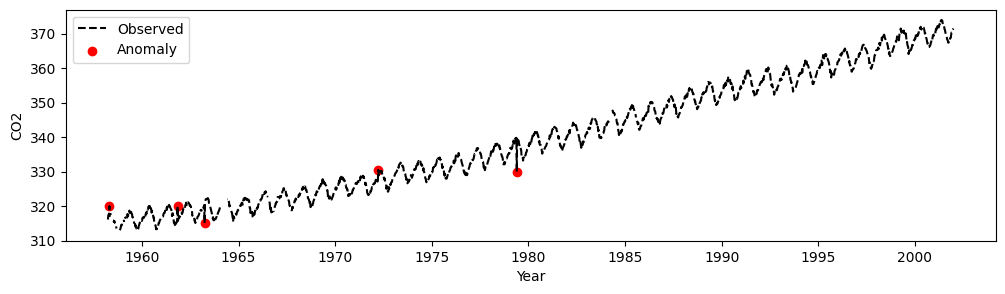

In [8]:
plt.figure(figsize=(12,3))
plt.plot(contam_airpassengers, color="k", linestyle="--", label="Observed")
plt.scatter(contam_airpassengers.index[anomaly_idx], anomaly_value, color='red', label='Anomaly')
plt.xlabel("Year")
plt.ylabel("CO2")
plt.legend()
# plt.savefig("../figures/contaminated_airpassengers.png", dpi=200)
plt.show()

In [9]:
airpassengers = airpassengers.co2.to_numpy()
airpassengers = airpassengers[~np.isnan(airpassengers), None]

contam_airpassengers = contam_airpassengers.co2.to_numpy()
contam_airpassengers = contam_airpassengers[~np.isnan(contam_airpassengers), None]

In [10]:
airpassengers = airpassengers[:1000]
contam_airpassengers = contam_airpassengers[:1000]

#### Identify anomaly points

LSTM trained without anomaly points

In [34]:
train_size = int(len(airpassengers) * 0.8)
test_size = len(airpassengers) - train_size
train, test = airpassengers[:train_size], airpassengers[train_size:]

In [35]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([799, 1, 1]) torch.Size([799, 1, 1])
torch.Size([199, 1, 1]) torch.Size([199, 1, 1])


In [36]:
model = Forecaster()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [37]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 318.8099, test RMSE 329.1214
Epoch 100: train RMSE 15.9841, test RMSE 25.7239
Epoch 200: train RMSE 4.7760, test RMSE 10.8684
Epoch 300: train RMSE 4.5879, test RMSE 10.9154
Epoch 400: train RMSE 4.2639, test RMSE 9.4130
Epoch 500: train RMSE 3.8205, test RMSE 6.9856
Epoch 600: train RMSE 3.2810, test RMSE 8.0144
Epoch 700: train RMSE 2.1102, test RMSE 4.2932
Epoch 800: train RMSE 1.3672, test RMSE 3.3496
Epoch 900: train RMSE 1.5781, test RMSE 1.2211
Epoch 1000: train RMSE 1.2881, test RMSE 0.8125
Epoch 1100: train RMSE 0.9444, test RMSE 0.7849
Epoch 1200: train RMSE 0.7342, test RMSE 1.5485
Epoch 1300: train RMSE 0.5774, test RMSE 1.0356
Epoch 1400: train RMSE 1.3811, test RMSE 0.6881
Epoch 1500: train RMSE 0.5853, test RMSE 1.0101
Epoch 1600: train RMSE 0.6244, test RMSE 0.9047
Epoch 1700: train RMSE 0.5973, test RMSE 0.9698
Epoch 1800: train RMSE 0.5474, test RMSE 1.1438
Epoch 1900: train RMSE 0.9178, test RMSE 0.6984


In [38]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(airpassengers) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(airpassengers) * np.nan
    test_plot[train_size+lookback:len(airpassengers)] = model(X_test)[:, -1, :]

In [39]:
test_mae = mean_absolute_error(model(X_test).detach().numpy().flatten(), y_test.flatten())
test_r2 = r2_score(model(X_test).detach().numpy().flatten(), y_test.flatten())

LSTM trained with anomaly points

In [40]:
train_size = int(len(contam_airpassengers) * 0.8)
test_size = len(contam_airpassengers) - train_size
train, test = contam_airpassengers[:train_size], contam_airpassengers[train_size:]

In [41]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([799, 1, 1]) torch.Size([799, 1, 1])
torch.Size([199, 1, 1]) torch.Size([199, 1, 1])


In [42]:
contam_model = Forecaster()
optimizer = optim.Adam(contam_model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [43]:
n_epochs = 2000
for epoch in range(n_epochs):
    contam_model.train()
    for X_batch, y_batch in loader:
        y_pred = contam_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    contam_model.eval()
    with torch.no_grad():
        y_pred = contam_model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = contam_model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 318.6325, test RMSE 328.9383
Epoch 100: train RMSE 15.3065, test RMSE 25.0095
Epoch 200: train RMSE 4.8020, test RMSE 10.6096
Epoch 300: train RMSE 4.7782, test RMSE 10.0265
Epoch 400: train RMSE 4.9044, test RMSE 7.9271
Epoch 500: train RMSE 4.4117, test RMSE 6.8598
Epoch 600: train RMSE 3.4713, test RMSE 5.7999
Epoch 700: train RMSE 2.5075, test RMSE 6.2474
Epoch 800: train RMSE 1.7625, test RMSE 3.9107
Epoch 900: train RMSE 1.2361, test RMSE 3.0395
Epoch 1000: train RMSE 0.8889, test RMSE 2.0301
Epoch 1100: train RMSE 0.9054, test RMSE 1.9423
Epoch 1200: train RMSE 1.1726, test RMSE 2.1258
Epoch 1300: train RMSE 1.0310, test RMSE 0.7580
Epoch 1400: train RMSE 1.2452, test RMSE 2.1206
Epoch 1500: train RMSE 1.9667, test RMSE 0.8801
Epoch 1600: train RMSE 0.7698, test RMSE 0.9395
Epoch 1700: train RMSE 0.9347, test RMSE 0.8025
Epoch 1800: train RMSE 1.3802, test RMSE 0.6731
Epoch 1900: train RMSE 0.6827, test RMSE 1.1934


In [44]:
with torch.no_grad():
    # shift train predictions for plotting
    contam_train_plot = np.ones_like(contam_airpassengers) * np.nan
    y_pred = contam_model(X_train)
    y_pred = y_pred[:, -1, :]
    contam_train_plot[lookback:train_size] = contam_model(X_train)[:, -1, :]
    # shift test predictions for plotting
    contam_test_plot = np.ones_like(contam_airpassengers) * np.nan
    contam_test_plot[train_size+lookback:len(contam_airpassengers)] = contam_model(X_test)[:, -1, :]

In [45]:
contam_test_mae = mean_absolute_error(contam_model(X_test).detach().numpy().flatten(), y_test.flatten())
contam_test_r2 = r2_score(contam_model(X_test).detach().numpy().flatten(), y_test.flatten())

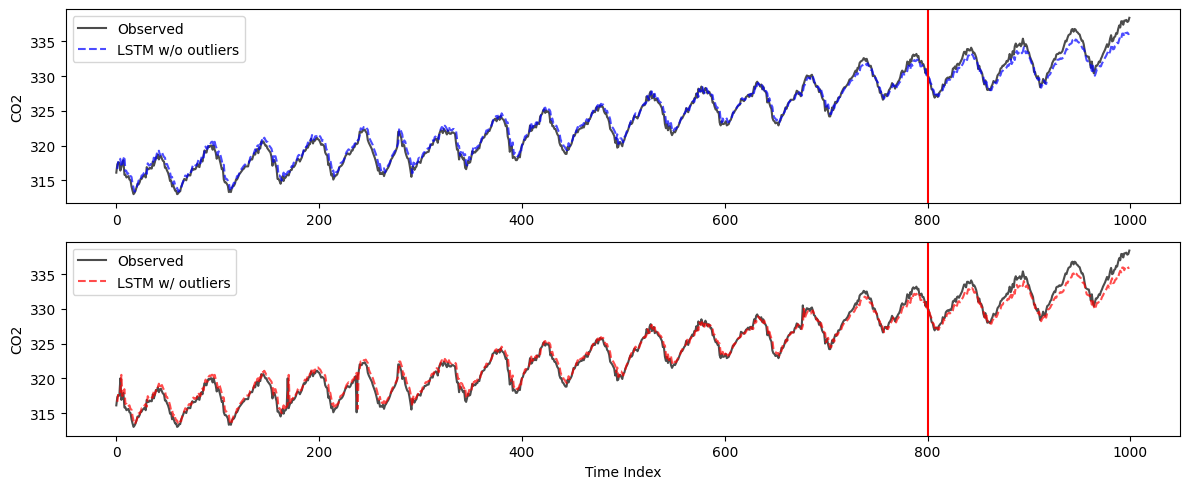

In [46]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,5))

ax1.plot(airpassengers, c='k', label="Observed", alpha=.7)
ax1.plot(train_plot, c='b', linestyle="--", alpha=.7)
ax1.plot(test_plot, c='b', linestyle="--", label="LSTM w/o outliers", alpha=.7)
ax1.axvline(x=train_size, c="r")
ax1.set_ylabel("CO2")
ax1.legend()
# ax1.set_title(f"Test R2: {test_r2:.4f}")

ax2.plot(contam_airpassengers, c='k', label="Observed", alpha=.7)
ax2.plot(contam_train_plot, c='r', linestyle="--", alpha=.7)
ax2.plot(contam_test_plot, c='r', linestyle="--", label="LSTM w/ outliers", alpha=.7)
ax2.set_xlabel("Time Index")
ax2.set_ylabel("CO2")
ax2.axvline(x=train_size, c="r")
ax2.legend()
# ax2.set_title(f"Test R2: {contam_test_r2:.4f}")

plt.tight_layout()
plt.savefig("../figures/airpassengers_predictions.png", dpi=200)
plt.show()

In [47]:
train_set = data.TensorDataset(X_train, y_train)
test_set = data.TensorDataset(X_test, y_test)

In [48]:
module = CGInfluenceModule(
    model=contam_model,
    objective=TimeSeriesObjective(),
    train_loader=data.DataLoader(train_set, batch_size=8),
    test_loader=data.DataLoader(test_set, batch_size=8),
    device=DEVICE,
    damp=0.001,
    atol=1e-8,
    maxiter=500,
)

In [73]:
test_losses = F.mse_loss(contam_model(X_test), y_test, reduction="none")
test_idxs = torch.argsort(test_losses, dim=0, descending=True)[:5] # lower MSE better prediction
test_idxs = test_idxs.tolist()

In [74]:
saved_influences = []

all_train_idxs = list(range(X_train.shape[0]))
for test_idx in tqdm(test_idxs, desc="Computing Influences"):
    influences = module.influences(train_idxs=all_train_idxs, test_idxs=[test_idx[0][0]])
    saved_influences.append(influences)
    
train_influences = torch.stack(saved_influences).mean(0)

Computing Influences: 100%|███████████████████████| 5/5 [05:01<00:00, 60.30s/it]


In [75]:
most_helpful_points = torch.argsort(train_influences, descending=True)[:3]
most_harmful_points = torch.argsort(train_influences)[:3]

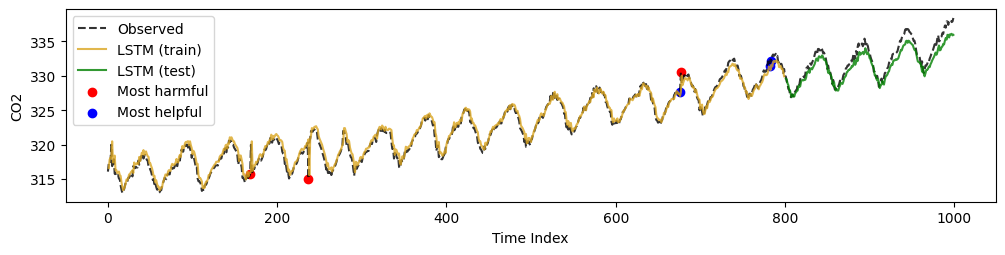

In [76]:
plt.figure(figsize=(12,2.5))
plt.plot(contam_airpassengers, c='k', linestyle="--", label="Observed", alpha=.8)
plt.plot(contam_train_plot, c='goldenrod', label="LSTM (train)", alpha=.8)
plt.plot(contam_test_plot, c='g', label="LSTM (test)", alpha=.8)
plt.scatter(most_harmful_points, 
            X_train.squeeze()[most_harmful_points], 
            color='red', label='Most harmful')
plt.scatter(most_helpful_points, 
            X_train.squeeze()[most_helpful_points], 
            color='blue', label='Most helpful')
plt.xlabel("Time Index")
plt.ylabel("CO2")
plt.legend()
plt.savefig("../figures/airpassengers_identified_anomalies.png", dpi=200)
plt.show()

#### Identify time intervals containing anomaly points

LSTM trained without anomaly points

In [95]:
train_size = int(len(airpassengers) * 0.8)
test_size = len(airpassengers) - train_size
train, test = airpassengers[:train_size], airpassengers[train_size:]

In [96]:
lookback = 3
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([797, 3, 1]) torch.Size([797, 3, 1])
torch.Size([197, 3, 1]) torch.Size([197, 3, 1])


In [70]:
model = Forecaster()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [71]:
n_epochs = 1500
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 318.8140, test RMSE 329.1151
Epoch 100: train RMSE 107.3191, test RMSE 117.3469
Epoch 200: train RMSE 22.6824, test RMSE 25.3575
Epoch 300: train RMSE 8.7991, test RMSE 13.3886
Epoch 400: train RMSE 3.9303, test RMSE 8.3542
Epoch 500: train RMSE 3.1955, test RMSE 7.0081
Epoch 600: train RMSE 2.9034, test RMSE 6.4260
Epoch 700: train RMSE 2.6826, test RMSE 6.2314
Epoch 800: train RMSE 2.7272, test RMSE 4.8408
Epoch 900: train RMSE 2.4066, test RMSE 4.6895
Epoch 1000: train RMSE 2.1417, test RMSE 4.2742
Epoch 1100: train RMSE 1.8745, test RMSE 4.3231
Epoch 1200: train RMSE 1.6790, test RMSE 3.2812
Epoch 1300: train RMSE 1.5416, test RMSE 3.4730
Epoch 1400: train RMSE 1.6896, test RMSE 3.6697


In [80]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(airpassengers) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(airpassengers) * np.nan
    test_plot[train_size+lookback:len(airpassengers)] = model(X_test)[:, -1, :]

In [97]:
test_mae = mean_absolute_error(model(X_test)[:,-1,:].detach().numpy().flatten(), y_test[:,-1,:].flatten())
test_r2 = r2_score(model(X_test)[:,-1,:].detach().numpy().flatten(), y_test[:,-1,:].flatten())

LSTM trained with anomaly points

In [98]:
train_size = int(len(contam_airpassengers) * 0.8)
test_size = len(contam_airpassengers) - train_size
train, test = contam_airpassengers[:train_size], contam_airpassengers[train_size:]

In [99]:
lookback = 3
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([797, 3, 1]) torch.Size([797, 3, 1])
torch.Size([197, 3, 1]) torch.Size([197, 3, 1])


In [14]:
contam_model = Forecaster()
optimizer = optim.Adam(contam_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [15]:
n_epochs = 1500
for epoch in range(n_epochs):
    contam_model.train()
    for X_batch, y_batch in loader:
        y_pred = contam_model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    contam_model.eval()
    with torch.no_grad():
        y_pred = contam_model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = contam_model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 319.3896, test RMSE 329.6867
Epoch 100: train RMSE 89.3782, test RMSE 99.2752
Epoch 200: train RMSE 15.5365, test RMSE 18.6882
Epoch 300: train RMSE 4.6686, test RMSE 10.0125
Epoch 400: train RMSE 3.0643, test RMSE 6.8548
Epoch 500: train RMSE 2.9282, test RMSE 6.2235
Epoch 600: train RMSE 2.7599, test RMSE 5.8964
Epoch 700: train RMSE 2.7272, test RMSE 6.0854
Epoch 800: train RMSE 3.0392, test RMSE 4.3121
Epoch 900: train RMSE 2.5660, test RMSE 5.9094
Epoch 1000: train RMSE 1.9966, test RMSE 4.7644
Epoch 1100: train RMSE 1.6855, test RMSE 3.8929
Epoch 1200: train RMSE 1.4800, test RMSE 3.2971
Epoch 1300: train RMSE 1.9540, test RMSE 4.0104
Epoch 1400: train RMSE 1.3129, test RMSE 1.4904


In [16]:
with torch.no_grad():
    # shift train predictions for plotting
    contam_train_plot = np.ones_like(contam_airpassengers) * np.nan
    y_pred = contam_model(X_train)
    y_pred = y_pred[:, -1, :]
    contam_train_plot[lookback:train_size] = contam_model(X_train)[:, -1, :]
    # shift test predictions for plotting
    contam_test_plot = np.ones_like(contam_airpassengers) * np.nan
    contam_test_plot[train_size+lookback:len(contam_airpassengers)] = contam_model(X_test)[:, -1, :]

In [100]:
contam_test_mae = mean_absolute_error(contam_model(X_test)[:,-1,:].detach().numpy().flatten(), y_test[:,-1,:].flatten())
contam_test_r2 = r2_score(contam_model(X_test)[:,-1,:].detach().numpy().flatten(), y_test[:,-1,:].flatten())

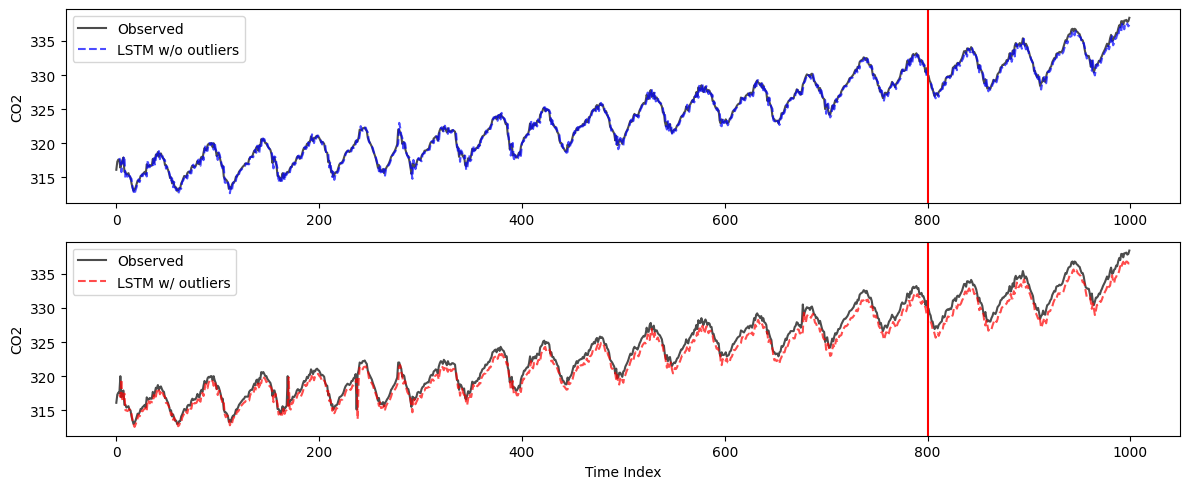

In [104]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,5))

ax1.plot(airpassengers, c='k', label="Observed", alpha=.7)
ax1.plot(train_plot, c='b', linestyle="--", alpha=.7)
ax1.plot(test_plot, c='b', linestyle="--", label="LSTM w/o outliers", alpha=.7)
ax1.axvline(x=train_size, c="r")
ax1.set_ylabel("CO2")
ax1.legend()
# ax1.set_title(f"Test R2: {test_r2:.4f}")

ax2.plot(contam_airpassengers, c='k', label="Observed", alpha=.7)
ax2.plot(contam_train_plot, c='r', linestyle="--", alpha=.7)
ax2.plot(contam_test_plot, c='r', linestyle="--", label="LSTM w/ outliers", alpha=.7)
ax2.set_xlabel("Time Index")
ax2.set_ylabel("CO2")
ax2.axvline(x=train_size, c="r")
ax2.legend()
# ax2.set_title(f"Test R2: {contam_test_r2:.4f}")

plt.tight_layout()
plt.savefig("../figures/airpassengers_predictions_time_intervals.png", dpi=200)
plt.show()

In [19]:
train_set = data.TensorDataset(X_train, y_train)
test_set = data.TensorDataset(X_test, y_test)

In [20]:
module = CGInfluenceModule(
    model=contam_model,
    objective=TimeSeriesObjective(),
    train_loader=data.DataLoader(train_set, batch_size=8),
    test_loader=data.DataLoader(test_set, batch_size=8),
    device=DEVICE,
    damp=0.001,
    atol=1e-8,
    maxiter=500,
)

In [21]:
test_losses = F.mse_loss(contam_model(X_test), y_test, reduction="none")
test_idxs = torch.argsort(test_losses.mean(1), dim=0, descending=True)[:5] # lower MSE better prediction
test_idxs = test_idxs.tolist()

In [22]:
saved_influences = []

all_train_idxs = list(range(X_train.shape[0]))
for test_idx in tqdm(test_idxs, desc="Computing Influences"):
    influences = module.influences(train_idxs=all_train_idxs, test_idxs=[test_idx[0]])
    saved_influences.append(influences)
    
train_influences = torch.stack(saved_influences).mean(0)

Computing Influences: 100%|██████████████████████| 5/5 [27:16<00:00, 327.32s/it]


In [64]:
most_helpful_points = torch.argsort(train_influences, descending=True)[:5]
most_harmful_points = torch.argsort(train_influences)[:5]

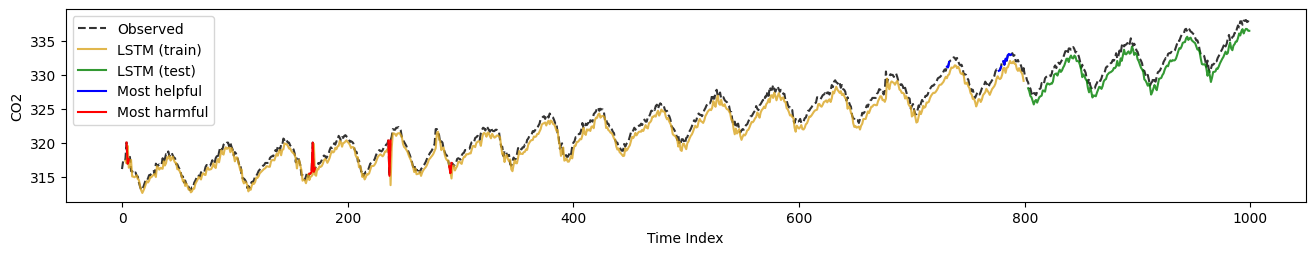

In [67]:
plt.figure(figsize=(16,2.5))
plt.plot(contam_airpassengers, c='k', linestyle="--", label="Observed", alpha=.8)
plt.plot(contam_train_plot, c='goldenrod', label="LSTM (train)", alpha=.8)
plt.plot(contam_test_plot, c='g', label="LSTM (test)", alpha=.8)

helpful_intervals = np.ones_like(contam_airpassengers) * np.nan
for _, point_idx in enumerate(most_helpful_points):
    interval_idxs = [point_idx, point_idx+1, point_idx+2]
    helpful_intervals[interval_idxs] = X_train[point_idx]

harmful_intervals = np.ones_like(contam_airpassengers) * np.nan
for _, point_idx in enumerate(most_harmful_points):
    interval_idxs = [point_idx, point_idx+1, point_idx+2]
    harmful_intervals[interval_idxs] = X_train[point_idx]

plt.plot(helpful_intervals, color='blue', label='Most helpful')
plt.plot(harmful_intervals, color='red', label='Most harmful')

plt.xlabel("Time Index")
plt.ylabel("CO2")
plt.legend()
# plt.savefig("../figures/airpassengers_identified_anomalies_time_intervals.png", dpi=200)
plt.show()

#### Contiguous anomaly points